# Training Multinomial Naive Bayes on RuSentiTweet
Multinomial Naive Bayes classification algorithm tends to be a baseline solution for sentiment analysis task. The basic idea of Naïve Bayes technique is to find the probabilities of classes assigned to texts by using the joint probabilities of words and classes. Given the dependent feature vector $(x_1, \dots, x_n)$ and the class $C_k$. Bayes' theorem is stated mathematically as the following relationship:
$$
\begin{align}
P(C_k \mid x_1,\dots,x_n) = \frac{P(C_k)P(x_1,\dots,x_n \mid C_k)}{P(x_1,\dots,x_n)}
\end{align}
$$
According to the "naive" conditional independence assumptions, for the given class $C_k$ each feature $x_{i}$ is conditionally independent of every other feature $x_{j}$ for$j\neq i$.
$$
\begin{align}
P(x_i \mid C_k,x_1,\dots,x_n) = P(x_i \mid C_k)
\end{align}
$$
Thus, the relation can be simplified to
$$
\begin{align}
P(C_k \mid x_1,\dots,x_n) = \frac{P(C_k)\prod_{i=1}^{n}P(x_i \mid C_k)}{P(x_1,\dots,x_n)}
\end{align}
$$
Since $P(x_1,...x_n)$ is constant, if the values of the feature variables are known, the following classification rule can be used:
$$
\begin{align}
P(C_k \mid x_1,\dots,x_n) \propto  P(C_k)\prod_{i=1}^{n}P(x_i \mid C_k) \\ \Downarrow \\ \hat{y} = \underset{k}{\arg\max} P(C_k)\prod_{i=1}^{n}P(x_i \mid C_k)
\end{align}
$$
To avoid underflow, log probabilities can be used.
$$
\begin{align}
\hat{y} = \underset{k}{\arg\max}(\ln{P(C_k)}+\sum_{i=1}^{n}\ln{P(x_i \mid C_k)})
\end{align}
$$
The variaty of naive Bayes classifiers primarly differs between each other by the assumptions they make regarding the distribution of $P(x_i \mid C_k)$, while $P(C_k)$ is usually defined as the relative frequency of class $C_k$ in the training dataset.

The multinomial distribution is parametrized by vectors $\theta_k = (\theta_{k1},\ldots,\theta_{kn})$ for each class $C_k$, where $n$ is the number of features (i.e. the size of the vocabulary) and $\theta_{ki}$ is the probability $P(x_i \mid C_k)$ of feature $i$ appearing in a sample that belongs to the class $C_k$.

The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:
$$
\begin{align}
\hat{\theta}_{ki} = \frac{ N_{ki} + \alpha}{N_k + \alpha n}
\end{align}
$$
where $N_{ki} = \sum_{x \in T} x_i$ is the number of times feature $i$ appears in a sample of class y in the training set $T$, and $N_{y} = \sum_{i=1}^{|T|} N_{ki}$ is the total count of all features for class $C_k$. The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha = 1$ is called Laplace smoothing, while $\alpha < 1$ is called Lidstone smoothing.

Thus, the final decision rule is defined as follows:
$$
\begin{align}
\hat{y} = \underset{k}{\arg\max}(\ln{P(C_k)}+\sum_{i=1}^{n}\ln{\frac{ N_{ki} + \alpha}{N_k + \alpha n}})
\end{align}
$$



## 1. Loading data

In [1]:
import pandas as pd
import numpy as np

In [4]:
# Read the data from CSV files
df_rusentitweet_train = pd.read_csv('rusentitweet_train_v2.csv')
df_rusentitweet_test = pd.read_csv('rusentitweet_test_v2.csv')

In [6]:
from numpy.random import randint

from sklearn import preprocessing

import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

le = preprocessing.LabelEncoder()
le.fit(df_rusentitweet_train['label'])
true_classes = le.transform(df_rusentitweet_test['label'])

## 2. Preprocessing data
Texts generated by humans in social media sites contain lots of noise that can significantly affect the results of the sentiment classification process. Moreover, depending on the features generation approach, every new term seems to add at least one new dimension to the feature space. That makes the feature space more sparse and high-dimensional. Consequently, the task of the classifier has become more complex.

To prepare messages, such text preprocessing techniques as replacing URLs and usernames with keywords, removing punctuation marks and converting to lowercase were used in this program. 

In [7]:
import re

def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = text.lower().replace("ё", "е")
    text = re.sub(' +',' ', text)
    return text.strip()

df_rusentitweet_train['text'] = [preprocess_text(t) for t in df_rusentitweet_train['text']]
df_rusentitweet_test['text'] = [preprocess_text(t) for t in df_rusentitweet_test['text']]

## 3. Training MultinomialNB
A Pipeline class was used to make the vectorizer => transformer => classifier easier to work with. Such hyper-parameters as n-grams range, IDF usage, TF-IDF normalization type and Naive Bayes alpha were tunned using grid search. The performance of the selected hyper-parameters was measured on a test set that was not used during the model training step.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

The dataset was plited into train and test subsets.

In [9]:
x_train = df_rusentitweet_train['text']
x_test = df_rusentitweet_test['text']
y_train = df_rusentitweet_train['label']
y_test = df_rusentitweet_test['label']

In [10]:
from sklearn.metrics import classification_report

score = 'f1_macro'
print("# Tuning hyper-parameters for %s" % score)
print()
np.errstate(divide='ignore')
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring=score)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
                             clf.cv_results_['std_test_score'], 
                             clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
print(classification_report(y_test, clf.predict(x_test), digits=4))
print()

# Tuning hyper-parameters for f1_macro

Best parameters set found on development set:

{'clf__alpha': 0.01, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

Grid scores on development set:

0.158 (+/-0.052) for {'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
0.138 (+/-0.047) for {'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
0.204 (+/-0.026) for {'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__ngram_range': (2, 2)}
0.128 (+/-0.005) for {'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
0.121 (+/-0.004) for {'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
0.205 (+/-0.024) for {'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__ngram_range': (2, 2)}
0.351 (+/-0.021) for {'clf__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range

Normalized confusion matrix


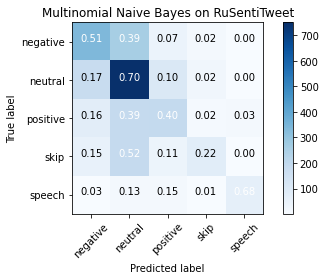

In [11]:
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim([4.5, -0.5])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.title('Multinomial Naive Bayes on RuSentiTweet')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion.png', dpi=300, bbox_inches = "tight")

    # Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, clf.predict(x_test))
np.set_printoptions(precision=2)

class_names = ['negative', 'neutral', 'positive', 'skip', 'speech'] 
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')